<img style="float: right;" src="https://docs.expert.ai/logo.png" width="150px">


# Sentiment Analysis with expert.ai NLAPI
expert.ai Natural Language API v2 introduces a sentiment analysis feature that identifies the sentiment polarity for text document such as positive, negative, overall and its associated intensity.

## Installation and Setup
First, install expert.ai-nlapi library using pip.
* https://pypi.org/project/expertai-nlapi/

In [142]:
!pip install -U expertai-nlapi

## Working with NL API in Python
First you have to setup your account credentials; if you don't have them, get them at https://developer.expert.ai/ui/login
Set your environment variables with your credentials 

```bash
SET EAI_USERNAME=YOUR_USER
SET EAI_PASSWORD=YOUR_PASSWORD
```

as an alternative you can always add to your notebook the following statements

```python
import os
os.environ["EAI_USERNAME"] = 'YOUR_USER'
os.environ["EAI_PASSWORD"] = 'YOUR_PASSWORD'
```



## Initialize the library



In [143]:
from expertai.nlapi.cloud.client import ExpertAiClient
client = ExpertAiClient()

In [144]:
text = '''Michael Jordan was one of the best basketball players 
of all time. Scoring was Jordan's stand-out skill, but he still holds a defensive NBA record.''' 
language= 'en'

As today, v2 provides the sentiment analysis feature in English only

## Let's play with it

Sentiment is availabble throught the `specific_resource_analysis` with the resource type `sentiment`

In [145]:
document = client.specific_resource_analysis(
    body={"document": {"text": text}}, 
    params={'language': language, 'resource': 'sentiment'
})

Sentiment feature takes in a string and returns a score for:
* negativity
* positivity
* overall (computed by normalizing the scores above)


In [146]:
document.sentiment.positivity

10.39

In [147]:
document.sentiment.negativity

0

In [148]:
document.sentiment.overall

10.39

During the sentiment analysis process, the terms that contributed to the score generation are reported, with their score.

In [149]:
print (f'{"TERM":{20}} {"SENTIMENT":{4}}')    

for item in document.sentiment.items:
    if not item.lemma:
        group_lemma=[]
        for nested in item.items:
            group_lemma.append(nested.lemma)
        print (f'{str(group_lemma):{20}} {item.sentiment:{10}}')
    else:
        print (f'{item.lemma:{20}} {item.sentiment:{10}}')

TERM                 SENTIMENT
['but']                      -1
basketball player             5
scoring                     9.5
skill                       3.5


# Sentiment Analysis on the movie review dataset

Let's apply now the  sentiment analysis to a dataset, i.e. the movie reviews dataset: we'll use a subset of the Cornell University Movie Review polarity dataset v2.0 obtained from http://www.cs.cornell.edu/people/pabo/movie-review-data/

The dataset contains the text of 2000 movie reviews: 1000 are positive, 1000 are negative, and the text has been preprocessed as a tab-delimited file. For demo purposes, We use a subset of this dataset, limited to 100 reviews per class.


In [150]:
import numpy as np
import pandas as pd

df = pd.read_csv('./moviereviews_100.tsv', sep='\t')
df.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,neg,my first press screening of 1998 and already i...
3,neg,"to put it bluntly , ed wood would have been pr..."
4,neg,"synopsis : melissa , a mentally-disturbed woma..."


In [151]:
df.shape

(200, 2)

In [152]:
df['label'].value_counts()

pos    100
neg    100
Name: label, dtype: int64

## Append to the dataset the sentiment result

First, we create a function that calls the API and returns the overall value.
Please note that the current API allows to process 10 kB size document maximum; for this reason in the function we reduce the text size accordingly.

In [153]:
def sentiment_overall(client, text, language):
    try:
        input_text = str(text)[0:10000]  # limit the input size
        document = client.specific_resource_analysis(
        body={"document": {"text": input_text}}, 
        params={'language':  language, 'resource': 'sentiment'
       })
        return document.sentiment.overall
    except Exception as e: 
        print(str(e) +": " + str(text))

The overall value is then stored in the dataset, creating a new column `overall`.

In [154]:
df['overall'] = df['review'].apply(lambda review: sentiment_overall(client, review, language))

df.head()

,label,review,overall
0,neg,how do films like mouse hunt get into theatres...,-12.00
1,neg,some talented actresses are blessed with a dem...,-9.39
2,neg,my first press screening of 1998 and already i...,-0.80
3,neg,"to put it bluntly , ed wood would have been pr...",-11.60
4,neg,"synopsis : melissa , a mentally-disturbed woma...",-6.69


Finally, we transform the value into `pos` and `neg` to be compared with the original dataset.

In [155]:
df['overall_score'] = df['overall'].apply(lambda c: 'pos' if c >=0 else 'neg')

df.head()

,label,review,overall,overall_score
0,neg,how do films like mouse hunt get into theatres...,-12.00,neg
1,neg,some talented actresses are blessed with a dem...,-9.39,neg
2,neg,my first press screening of 1998 and already i...,-0.80,neg
3,neg,"to put it bluntly , ed wood would have been pr...",-11.60,neg
4,neg,"synopsis : melissa , a mentally-disturbed woma...",-6.69,neg


## Perform a comparison analysis between the original `label` and `overall_score`

Now we compare the results with the annotated corpus, computing the precision and recall and then printing the confusion matrix. `sklearn` and `seaborn` packages need to be installed before proceeding.

In [156]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [157]:
print(classification_report(df['label'],df['overall_score']))

              precision    recall  f1-score   support

         neg       0.70      0.87      0.77       100
         pos       0.83      0.62      0.71       100

    accuracy                           0.74       200
   macro avg       0.76      0.74      0.74       200
weighted avg       0.76      0.74      0.74       200



In [160]:
cf_matrix = confusion_matrix(df['label'],df['overall_score'])

[[87 13]
 [38 62]]


<AxesSubplot:>

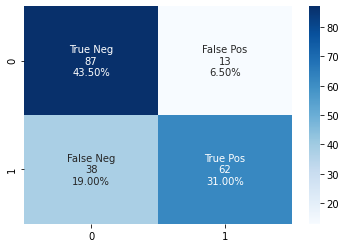

In [159]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [161]:
accuracy_score(df['label'],df['overall_score'])

0.745